In [ ]:
pip install deepxde

In [1]:
from deepxde.backend.set_default_backend import set_default_backend
set_default_backend("pytorch")

Using backend: pytorch



Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [3]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import math

import numpy as np
import pandas as pd
import pymssql
import pyodbc
from datetime import datetime, timedelta
import re
from dateutil.parser import parse
import glob
import argparse
import sys
import openpyxl as opx
import xlrd
import time
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import font_manager, rc
matplotlib.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from copy import deepcopy


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch

In [4]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [5]:

def ode_system(t, u):
    du_t = dde.grad.jacobian(u, t)
    return du_t - torch.cos(2*torch.pi*t)

In [6]:
def boundary(t, on_initial):
    return on_initial and np.isclose(t[0], 0)

In [7]:
geom = dde.geometry.TimeDomain(0, 2)

ic = dde.IC(geom, lambda t: 1, boundary)

# Reference solution to compute the error
def true_solution(t):
    return np.sin(2*np.pi*t)/(2*np.pi) + 1

data = dde.data.PDE(geom,
                    ode_system,
                    ic,
                    num_domain = 30, #collocation point
                    num_boundary = 2,
                    solution = true_solution,
                    num_test = 100)

In [8]:
layer_size = [1] + [32] + [1] # input, hidden, output
activation = "tanh"
initializer = "Glorot uniform"

NN = dde.maps.FNN(layer_size, activation, initializer)

In [9]:
model = dde.Model(data, NN)
model.compile("adam", lr = 0.001)

Compiling model...
'compile' took 0.000119 s



Training model...

Step      Train loss              Test loss               Test metric
0         [5.06e-01, 1.00e+00]    [4.95e-01, 1.00e+00]    []  
1000      [3.55e-01, 1.00e-03]    [3.65e-01, 1.00e-03]    []  
2000      [2.02e-01, 7.27e-07]    [2.15e-01, 7.27e-07]    []  
3000      [6.20e-02, 2.10e-06]    [6.73e-02, 2.10e-06]    []  
4000      [2.78e-03, 2.57e-08]    [2.76e-03, 2.57e-08]    []  
5000      [1.66e-03, 3.13e-09]    [1.21e-03, 3.13e-09]    []  
6000      [1.21e-03, 1.43e-07]    [8.68e-04, 1.43e-07]    []  

Best model at step 6000:
  train loss: 1.21e-03
  test loss: 8.68e-04
  test metric: []

'train' took 14.407778 s



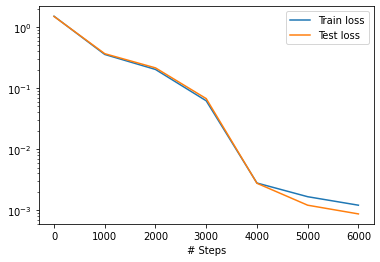

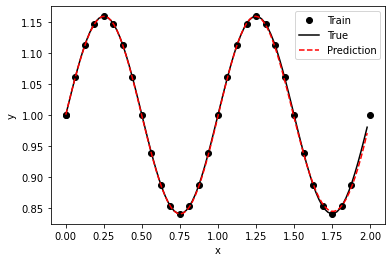

In [10]:
losshistory, train_state = model.train(epochs = 6000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

# 1. 예제 Euler beam
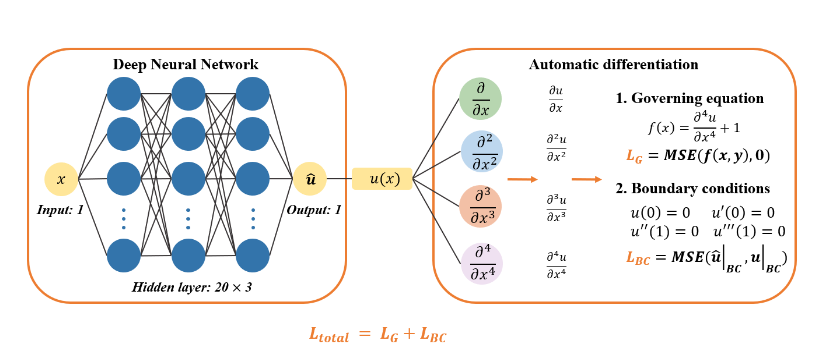

In [11]:
def dy(x, y):
    return dde.grad.jacobian(y,x) # 1번 미분

def ddy(x,y):
    return dde.grad.hessian(y,x) #2번미분

def dddy(x,y):
    return dde.grad.jacobian(ddy(x,y), x) #2번 미분한것을 한번 더 jacobian을 활용하여 미분하면 3번미분한 것이 됨 

def pde(x,y):
    dy_xx = ddy(x,y)
    dy_xxxx = dde.grad.hessian(dy_xx, x) #4번미분 
    return dy_xxxx +1 

## Define boundary condition

In [12]:
def boundary_left(x, on_boundary): # 아래 dde.geometry.Interval(0,1)에서 geometry 정의하면 자동으로 양끝단 boundary 설정됨
    return on_boundary and np.isclose(x[0], 0)

def boundary_right(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

## Define Geometry, Implement Boundary Condition

In [13]:
geom = dde.geometry.Interval(0, 1)

bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left) # u(0) = 0
bc2 = dde.OperatorBC(geom, lambda x, y, _: dy(x, y), boundary_left) # u'(0) = 0
bc3 = dde.OperatorBC(geom, lambda x, y, _: ddy(x, y), boundary_right) # u''(1) = 0
bc4 = dde.OperatorBC(geom, lambda x, y, _: dddy(x, y), boundary_right) # u'''(1) = 0

# Reference solution to compute the error
def true_solution(x):
    return -(x ** 4) / 24 + x ** 3 / 6 - x ** 2 / 4

data = dde.data.PDE(geom, 
                    pde, 
                    [bc1, bc2, bc3, bc4], 
                    num_domain = 10, # 10EA의 collocation point
                    num_boundary = 2,  # boundary에는 2EA의 collocation point
                    solution = true_solution, 
                    num_test = 100)


# Define Network and Hyper-parameters

In [14]:
layer_size = [1] + [20] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

In [15]:
model = dde.Model(data, net)
model.compile("adam", lr = 0.001)

Compiling model...
'compile' took 0.000261 s



Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.66e-01, 0.00e+00, 1.51e-02, 1.43e-02, 5.11e-03]    [4.19e-01, 0.00e+00, 1.51e-02, 1.43e-02, 5.11e-03]    []  
1000      [2.53e-04, 2.20e-08, 2.07e-08, 1.82e-06, 1.91e-07]    [1.70e-04, 2.20e-08, 2.07e-08, 1.82e-06, 1.91e-07]    []  
2000      [7.48e-05, 1.07e-08, 6.29e-07, 1.87e-07, 1.52e-07]    [6.00e-05, 1.07e-08, 6.29e-07, 1.87e-07, 1.52e-07]    []  
3000      [5.03e-05, 7.68e-11, 2.87e-09, 6.23e-08, 3.46e-08]    [5.72e-05, 7.78e-11, 2.92e-09, 6.24e-08, 3.45e-08]    []  
4000      [4.13e-05, 6.57e-11, 5.52e-10, 1.08e-08, 9.38e-09]    [4.75e-05, 6.72e-11, 5.68e-10, 1.08e-08, 9.36e-09]    []  
5000      [4.28e-05, 1.07e-07, 8.35e-07, 4.31e-07, 1.43e-07]    [4.96e-05, 1.07e-07, 8.35e-07, 4.31e-07, 1.43e-07]    []  

Best model at step 4000:
  train loss: 4.14e-05
  test loss: 4.75e-05
  test metric: []

'train' took 63.433837 

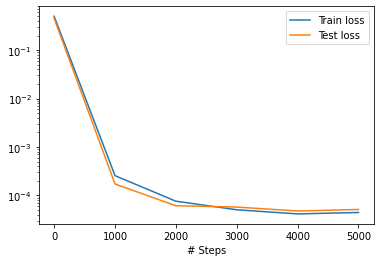

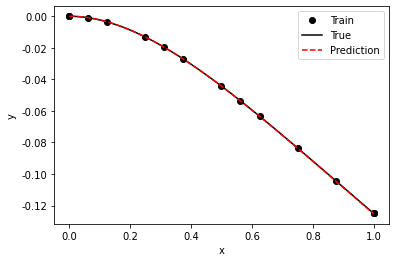

In [16]:
losshistory, train_state = model.train(epochs = 5000) # loss: [PDE MSE, BC1 MSE, BC2 MAX, BC3 MSC, BC4 MSC]
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

# 2 예제 2 평판형 유동, Navier-Stokes Eq
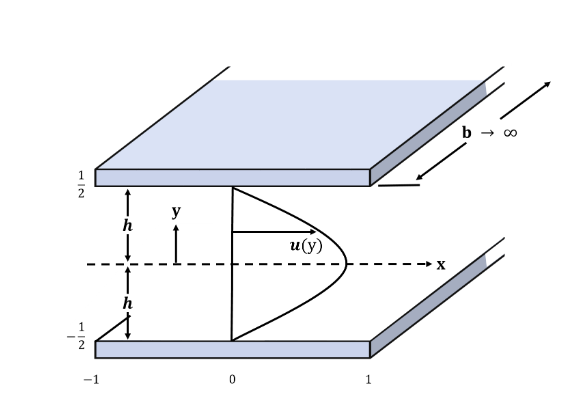
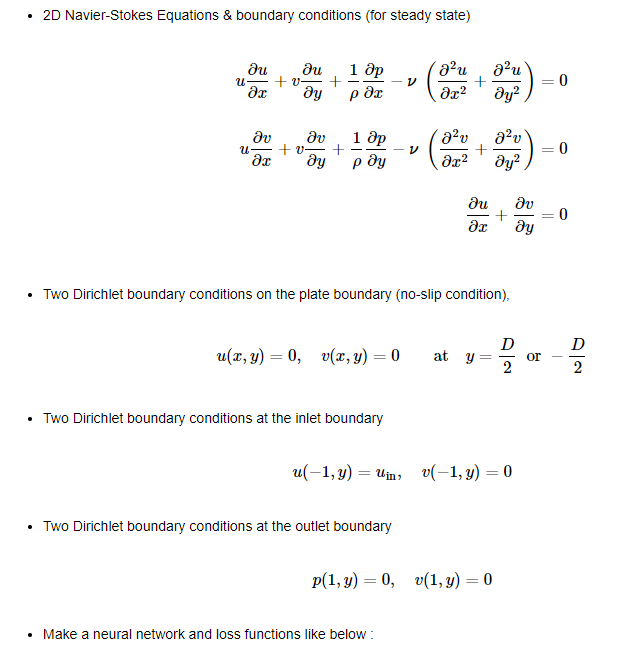

# 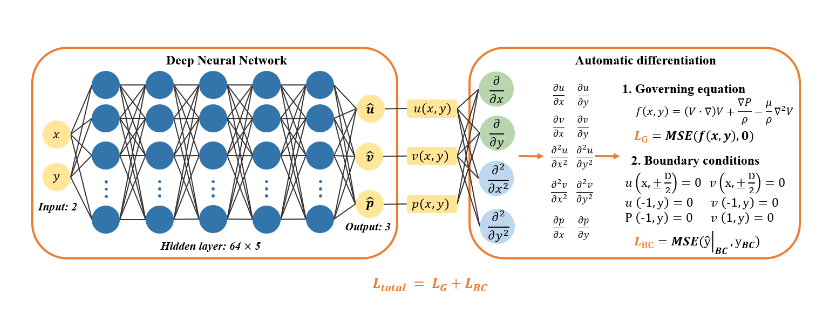
# x,y방향 속도, pressure 예측

In [17]:
# Properties
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

## Define PDE with Boundary & Inlet Conditions

In [18]:
def boundary_wall(X, on_boundary): #벽쪽 boundary condition
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [19]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0) # i=0의미: output Y의 첫번째값, j=1 의미: Input X의 첫번째값 (dudx)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0) # component가 0인경우 Y의 첫번째값
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)
    
    pde_u = Y[:,0:1]*du_x + Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy) #x방향의 Navier-Stokes
    pde_v = Y[:,0:1]*dv_x + Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy) #y방향의 Navier-Stokes
    pde_cont = du_x + dv_y # Continuity 

    return [pde_u, pde_v, pde_cont]

## 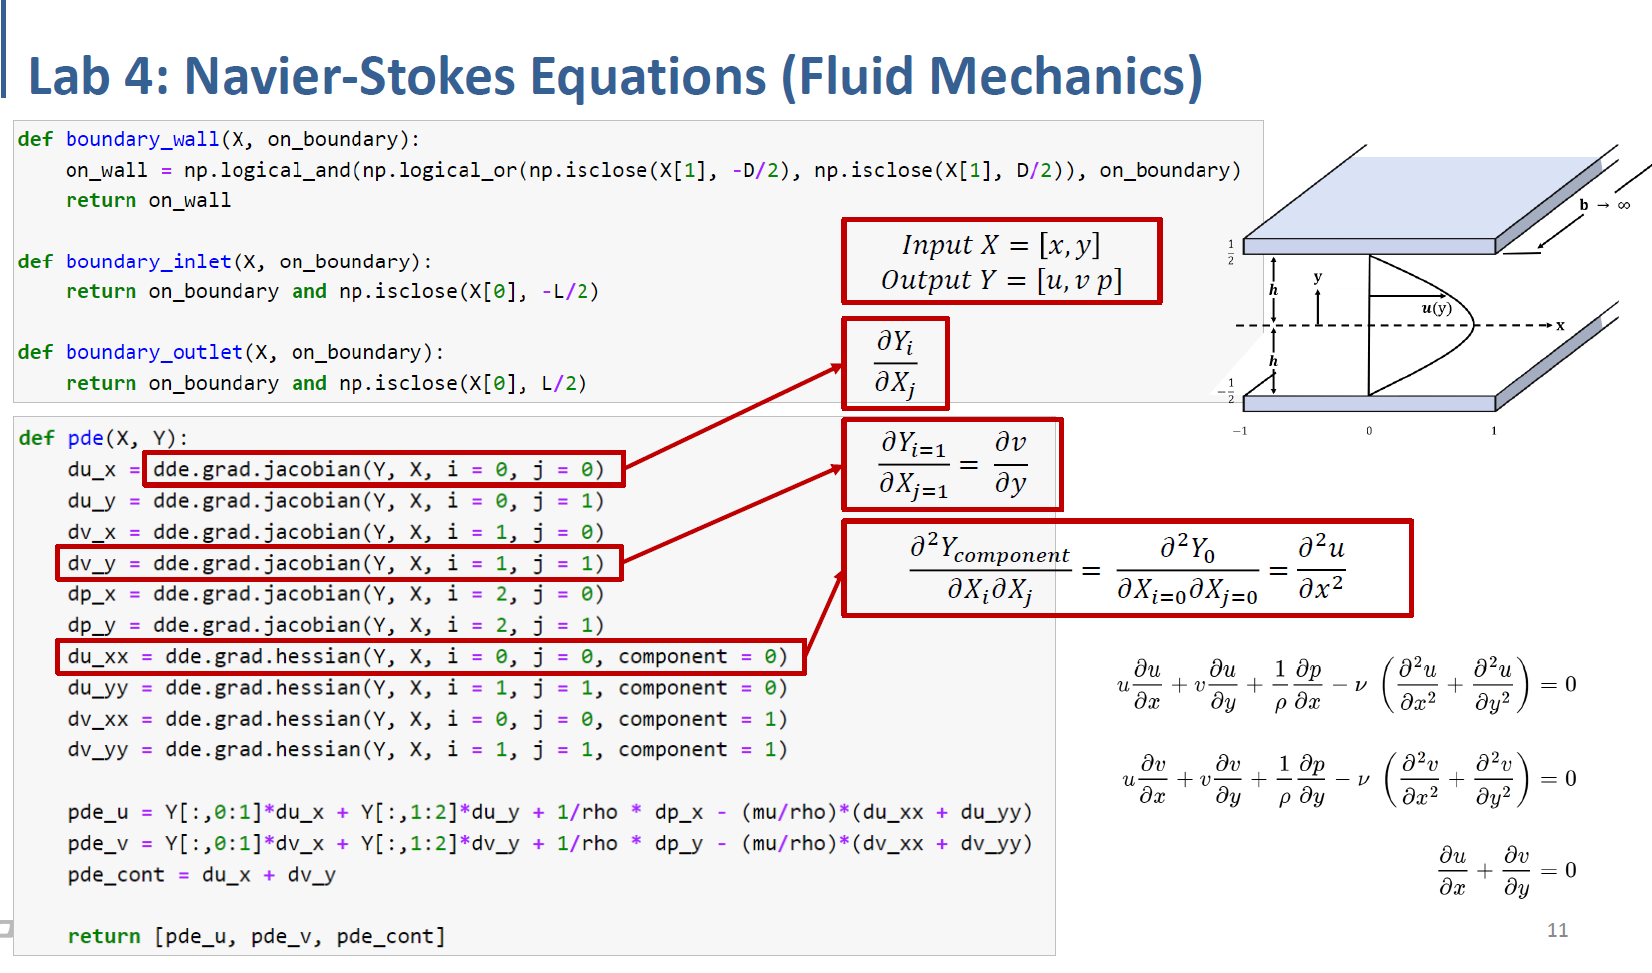

In [20]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

In [21]:
data = dde.data.PDE(geom, 
                    pde, 
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v], 
                    num_domain = 3000, 
                    num_boundary = 500, 
                    num_test = 1000,
                    train_distribution = 'LHS' ) # LHS: ddx에서 제공하는 데이터 샘플링 기법 중 1개, 라틴하이프느샘플링 기법 

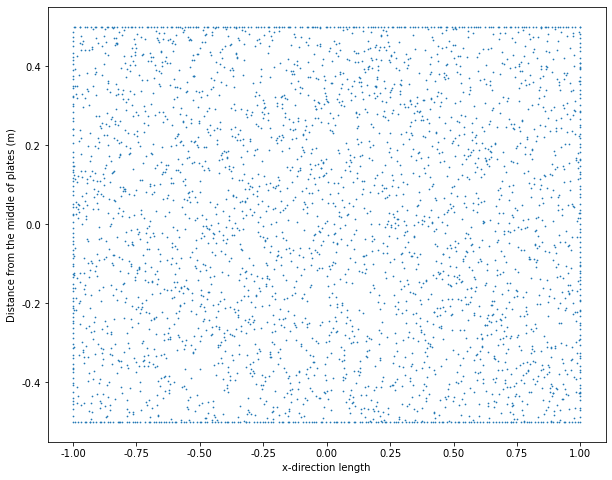

In [22]:
# 계산에 활용된 collocation point
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

In [23]:
layer_size = [2] + [64] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
'compile' took 0.000447 s



Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [5.62e-02, 6.02e-02, 3.77e-03, 2.91e-02, 6.38e-03, 1.29e+00, 1.42e-02, 1.49e-02, 1.42e-02]    [5.31e-02, 6.05e-02, 3.87e-03, 2.91e-02, 6.38e-03, 1.29e+00, 1.42e-02, 1.49e-02, 1.42e-02]    []  
1000      [1.20e-03, 6.15e-04, 7.78e-03, 3.17e-02, 1.59e-02, 4.02e-02, 1.76e-03, 7.61e-04, 2.30e-05]    [9.54e-04, 3.78e-04, 5.47e-03, 3.17e-02, 1.59e-02, 4.02e-02, 1.76e-03, 7.61e-04, 2.30e-05]    []  
2000      [2.00e-03, 5.31e-04, 4.77e-03, 2.53e-02, 1.29e-02, 3.09e-02, 9.13e-04, 3.34e-04, 6.42e-05]    [1.72e-03, 3.46e-04, 3.22e-03, 2.53e-02, 1.29e-02, 3.09e-02, 9.13e-04, 3.34e-04, 6.42e-05]    []  
3000      [4.30e-03, 1.02e-03, 4.03e-03, 2.19e-02, 1.13e-02, 2.33e-02, 2.66e-03, 1.31e-03, 8.02e-06]    [4.04e-03, 7.22e-04, 2.46e-03, 2.19e-02, 1.13e-02, 2.33e-0

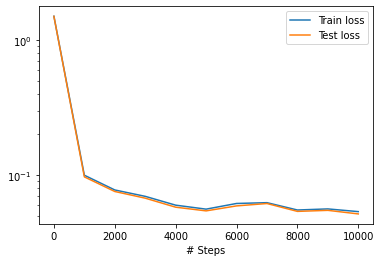

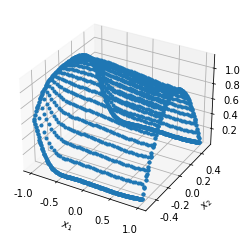

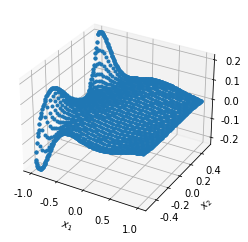

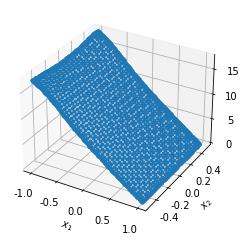

In [24]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

## Train More (L-BFGS optimizer)

Compiling model...
'compile' took 0.000365 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [4.19e-03, 1.31e-03, 2.10e-03, 1.76e-02, 6.22e-03, 1.61e-02, 6.01e-03, 2.08e-04, 3.12e-05]    [3.41e-03, 1.14e-03, 9.89e-04, 1.76e-02, 6.22e-03, 1.61e-02, 6.01e-03, 2.08e-04, 3.12e-05]    []  
11000     [5.84e-04, 7.92e-04, 1.32e-03, 1.05e-02, 1.69e-03, 7.04e-03, 3.13e-03, 3.42e-05, 8.00e-06]    [4.56e-04, 6.67e-04, 1.13e-03, 1.05e-02, 1.69e-03, 7.04e-03, 3.13e-03, 3.42e-05, 8.00e-06]    []  
12000     [5.00e-04, 3.71e-04, 6.46e-04, 7.61e-03, 1.42e-03, 5.25e-03, 1.92e-03, 1.82e-05, 2.78e-06]    [3.63e-04, 2.67e-04, 4.26e-04, 7.61e-03, 1.42e-03, 5.25e-03, 1.92e-03, 1.82e-05, 2.78e-06]    []  
13000     [4.76e-04, 3.51e-04, 4.54e-04, 5.85e-03, 1.23e-03, 4.34e-03, 1.62e-03, 3.86e-06, 6.60e-06]    [4.55e-04, 3

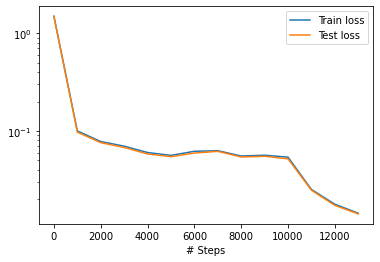

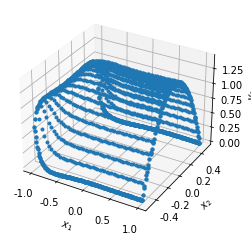

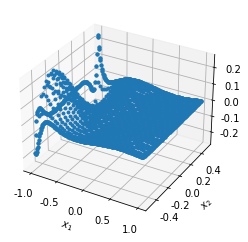

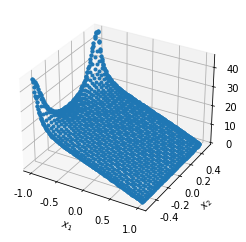

In [25]:
# 수렴잘되는 optimizer 사용 Hessian 행렬 추정시 사용, 추가학습  
# adam으로 한번 풀고 그 떄의 weight을 갖고, initial point를 갖고 두번째 optimizer 씀 
dde.optimizers.config.set_LBFGS_options(maxiter=3000)

model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

## Plot results (Adam + L-BFGS)

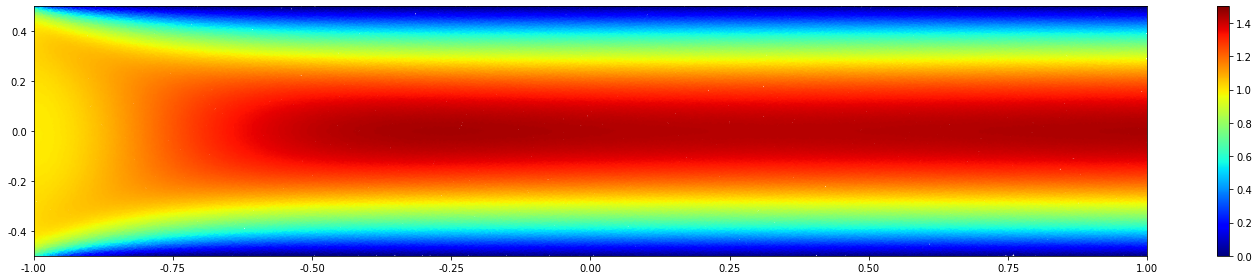

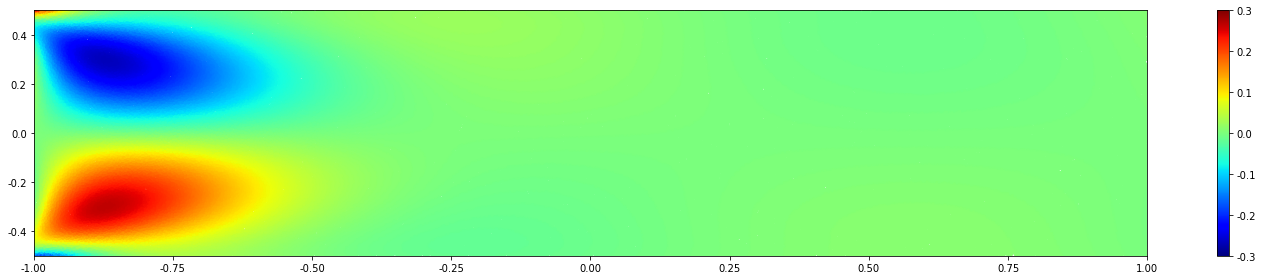

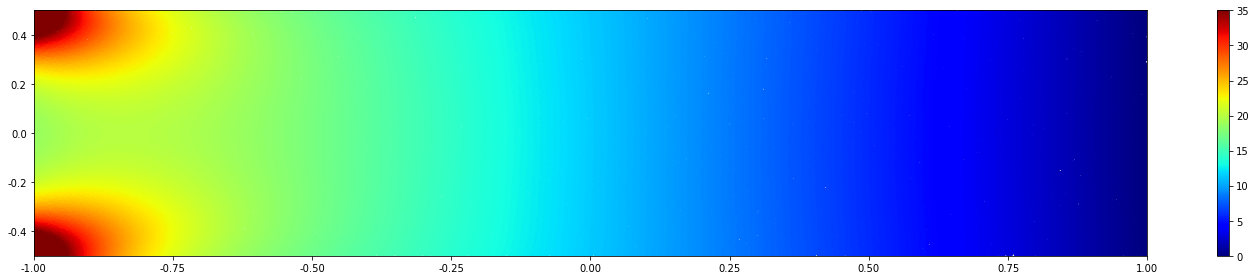

In [26]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

## Validation

In [28]:
# Analytic solution
x = np.ones([1000,1])
y = np.linspace(-0.5, 0.5, 1000).reshape(1000,1)
outlet = np.hstack([x, y])

analytic_solution = u_in * 1.5 * (1 - ((y)/(D/2))**2)

PINN_solution = model.predict(outlet)

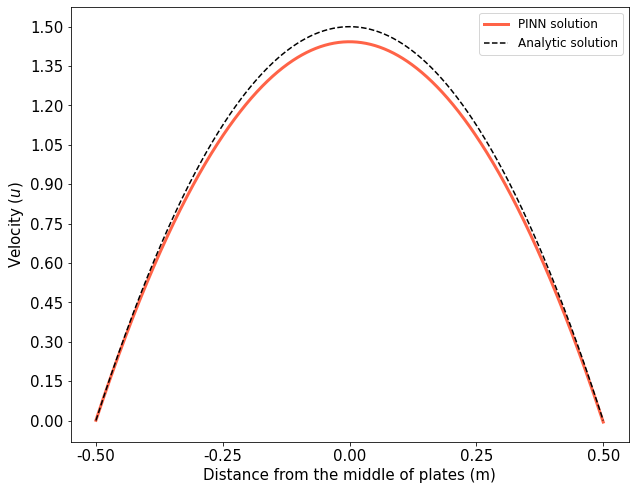

In [29]:
plt.figure(figsize = (10,8))
plt.plot(y, PINN_solution[:, 0], c = 'tomato', linewidth = 3, label = 'PINN solution')
plt.plot(y, analytic_solution, c = 'k', linestyle = '--', label = 'Analytic solution')
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize = 15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize = 15)
plt.legend(fontsize = 12)
plt.xlabel('Distance from the middle of plates (m)', fontsize = 15)
plt.ylabel('Velocity ($u$)', fontsize = 15)
plt.show()

# PINN with data

In [34]:
fluid_bigdata = np.load('fluid_bigdata.npy')

observe_x = fluid_bigdata[:, :2] # input (X좌표, y좌표)
observe_y = fluid_bigdata[:, 2:] # output (X방향속도, y방향속도, 압력)

In [42]:
observe_y.shape

(3360, 3)

In [35]:
observe_u = dde.icbc.PointSetBC(observe_x, observe_y[:, 0].reshape(-1, 1), component=0)
observe_v = dde.icbc.PointSetBC(observe_x, observe_y[:, 1].reshape(-1, 1), component=1)
observe_p = dde.icbc.PointSetBC(observe_x, observe_y[:, 2].reshape(-1, 1), component=2)

In [43]:
# Properties
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

In [44]:
geom = dde.geometry.Rectangle(xmin = [-L/2, -D/2], xmax = [L/2, D/2])
data = dde.data.PDE(geom,
                    None,
                    [observe_u, observe_v, observe_p], 
                    num_domain = 0, 
                    num_boundary = 0, 
                    num_test = 100)

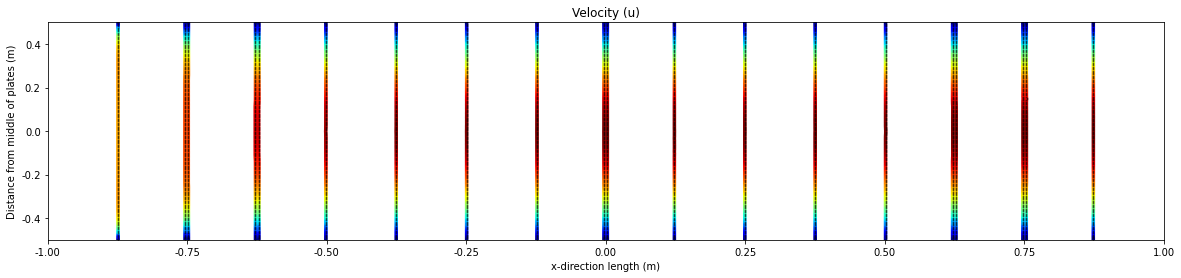

In [45]:
# 랜덤하게 계측안함. 계측포인트에 대한 내용임 
plt.figure(figsize = (20,4))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.scatter(observe_x[:, 0], observe_x[:, 1], c = observe_y[:, 0], s = 6.5, cmap = 'jet')
plt.scatter(observe_x[:, 0], observe_x[:, 1], s = 0.5, color='k', alpha = 0.5)
plt.xlim((0-L/2, L-L/2))
plt.ylim((0-D/2, D-D/2))
plt.xlabel('x-direction length (m)')
plt.ylabel('Distance from middle of plates (m)')
plt.title('Velocity (u)')
plt.show()

In [46]:
layer_size = [2] + [64] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
'compile' took 0.000276 s



In [47]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = False)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.25e+00, 8.08e-03, 2.00e+02]    [1.25e+00, 8.08e-03, 2.00e+02]    []  
1000      [1.76e-01, 5.15e-03, 4.95e-01]    [1.76e-01, 5.15e-03, 4.95e-01]    []  
2000      [3.28e-03, 1.95e-03, 5.78e-02]    [3.28e-03, 1.95e-03, 5.78e-02]    []  
3000      [1.18e-03, 9.20e-04, 4.39e-02]    [1.18e-03, 9.20e-04, 4.39e-02]    []  
4000      [5.55e-04, 3.03e-04, 8.05e-03]    [5.55e-04, 3.03e-04, 8.05e-03]    []  
5000      [3.26e-04, 1.45e-04, 2.52e-03]    [3.26e-04, 1.45e-04, 2.52e-03]    []  
6000      [1.99e-04, 9.25e-05, 6.10e-04]    [1.99e-04, 9.25e-05, 6.10e-04]    []  
7000      [1.15e-04, 7.31e-05, 2.78e-04]    [1.15e-04, 7.31e-05, 2.78e-04]    []  
8000      [7.64e-05, 5.01e-05, 1.75e-04]    [7.64e-05, 5.01e-05, 1.75e-04]    []  
9000      [5.90e-05, 3.93e-05, 1.33e-04]    [5.90e-05, 3.93e-05, 1.33e-04]    []  
10000     [5.25e-05, 3.55e-05, 7.36e-04]    [5.25e-05, 3.55e-

Compiling model...
'compile' took 0.000326 s

Training model...

Step      Train loss                        Test loss                         Test metric
10000     [5.25e-05, 3.55e-05, 7.36e-04]    [5.25e-05, 3.55e-05, 7.36e-04]    []  
11000     [4.41e-06, 2.34e-06, 3.56e-05]    [4.41e-06, 2.34e-06, 3.56e-05]    []  
12000     [3.11e-06, 8.99e-07, 2.17e-05]    [3.11e-06, 8.99e-07, 2.17e-05]    []  
13000     [2.51e-06, 8.83e-07, 1.37e-05]    [2.51e-06, 8.83e-07, 1.37e-05]    []  

Best model at step 13000:
  train loss: 1.71e-05
  test loss: 1.71e-05
  test metric: []

'train' took 30.094116 s



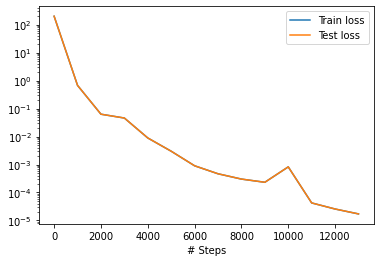

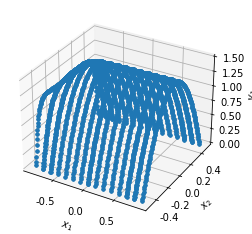

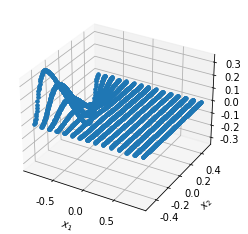

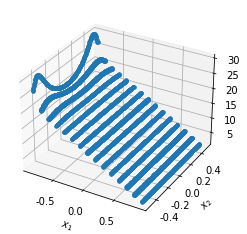

In [48]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

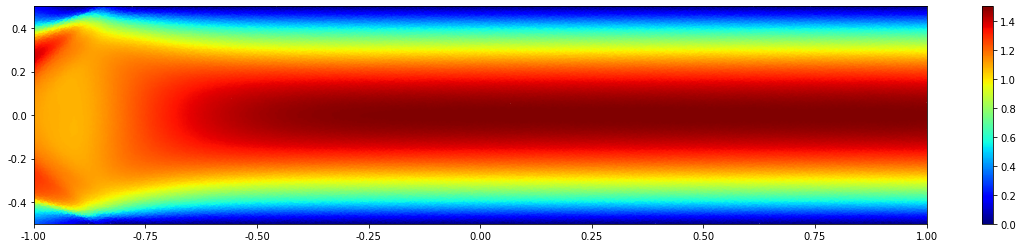

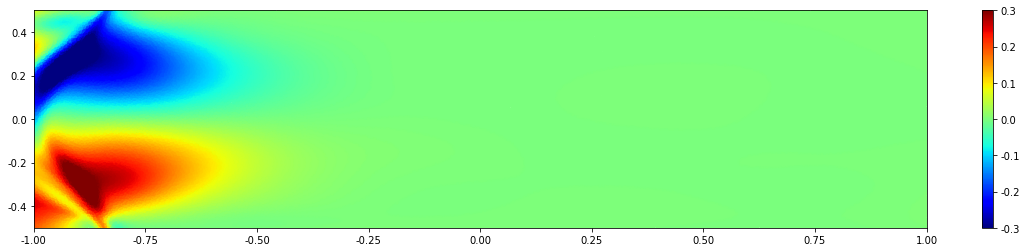

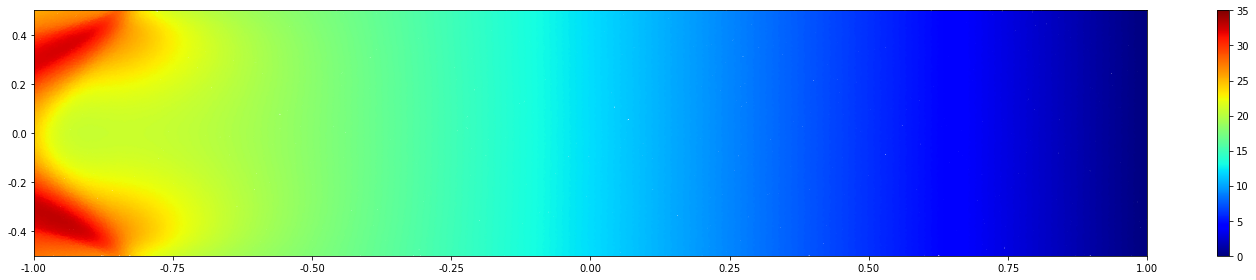

In [ ]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]

for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                s = 2,
                cmap = 'jet')
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
plt.tight_layout()
plt.show()

## Data-driven with small data

In [50]:
fluid_smalldata = np.load('fluid_smalldata.npy')

observe_x = fluid_smalldata[:, :2]
observe_y = fluid_smalldata[:, 2:]

In [51]:
observe_u = dde.icbc.PointSetBC(observe_x, observe_y[:, 0].reshape(-1, 1), component=0)
observe_v = dde.icbc.PointSetBC(observe_x, observe_y[:, 1].reshape(-1, 1), component=1)
observe_p = dde.icbc.PointSetBC(observe_x, observe_y[:, 2].reshape(-1, 1), component=2)

In [52]:
geom = dde.geometry.Rectangle(xmin = [-L/2, -D/2], xmax = [L/2, D/2])
data = dde.data.PDE(geom,
                    None,
                    [observe_u, observe_v, observe_p], 
                    num_domain = 0, 
                    num_boundary = 0, 
                    num_test = 120)

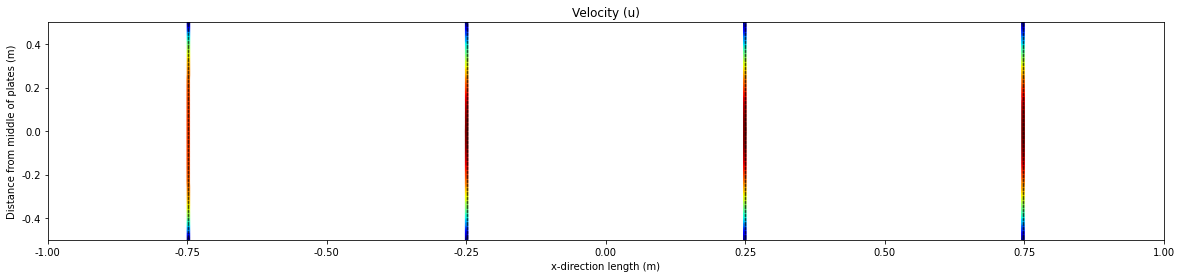

In [53]:
plt.figure(figsize = (20,4))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.scatter(observe_x[:, 0], observe_x[:, 1], c = observe_y[:, 0], s = 6.5, cmap = 'jet')
plt.scatter(observe_x[:, 0], observe_x[:, 1], s = 0.5, color='k', alpha = 0.5)
plt.xlim((0-L/2, L-L/2))
plt.ylim((0-D/2, D-D/2))
plt.xlabel('x-direction length (m)')
plt.ylabel('Distance from middle of plates (m)')
plt.title('Velocity (u)')
plt.show()

In [54]:
layer_size = [2] + [64] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
'compile' took 0.000142 s



In [55]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = False)

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.18e+00, 3.92e-02, 1.96e+02]    [1.18e+00, 3.92e-02, 1.96e+02]    []  
1000      [1.81e-01, 5.41e-03, 1.57e-01]    [1.81e-01, 5.41e-03, 1.57e-01]    []  
2000      [1.39e-02, 3.14e-03, 3.43e-02]    [1.39e-02, 3.14e-03, 3.43e-02]    []  
3000      [6.21e-04, 3.38e-04, 6.37e-03]    [6.21e-04, 3.38e-04, 6.37e-03]    []  
4000      [7.37e-05, 5.44e-05, 2.62e-04]    [7.37e-05, 5.44e-05, 2.62e-04]    []  
5000      [3.86e-05, 2.83e-05, 8.54e-05]    [3.86e-05, 2.83e-05, 8.54e-05]    []  
6000      [1.47e-04, 3.81e-05, 2.86e-02]    [1.47e-04, 3.81e-05, 2.86e-02]    []  
7000      [7.70e-05, 5.05e-05, 1.10e-02]    [7.70e-05, 5.05e-05, 1.10e-02]    []  
8000      [1.54e-05, 9.29e-06, 4.40e-05]    [1.54e-05, 9.29e-06, 4.40e-05]    []  
9000      [1.45e-05, 1.15e-05, 4.54e-05]    [1.45e-05, 1.15e-05, 4.54e-05]    []  
10000     [1.34e-05, 6.92e-06, 6.76e-05]    [1.34e-05, 6.92e-

samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]

for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                s = 2,
                cmap = 'jet')
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
plt.tight_layout()
plt.show() 

Compiling model...
'compile' took 0.001360 s

Training model...

Step      Train loss                        Test loss                         Test metric
13000     [5.58e-07, 4.97e-07, 1.29e-05]    [5.58e-07, 4.97e-07, 1.29e-05]    []  
14000     [5.56e-07, 4.94e-07, 1.29e-05]    [5.56e-07, 4.94e-07, 1.29e-05]    []  
15000     [5.55e-07, 4.93e-07, 1.29e-05]    [5.55e-07, 4.93e-07, 1.29e-05]    []  
16000     [5.55e-07, 4.92e-07, 1.29e-05]    [5.55e-07, 4.92e-07, 1.29e-05]    []  

Best model at step 16000:
  train loss: 1.40e-05
  test loss: 1.40e-05
  test metric: []

'train' took 9.721614 s



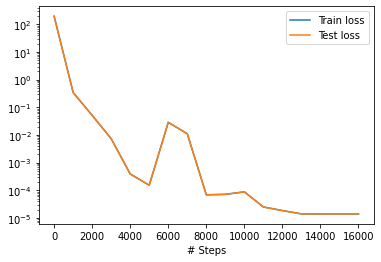

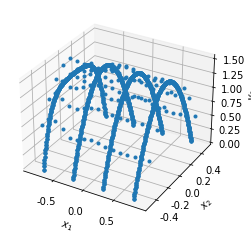

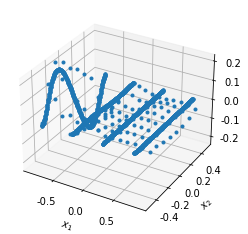

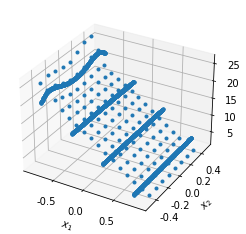

In [58]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

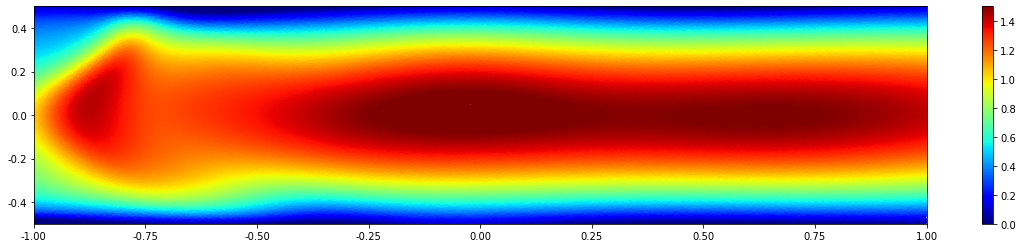

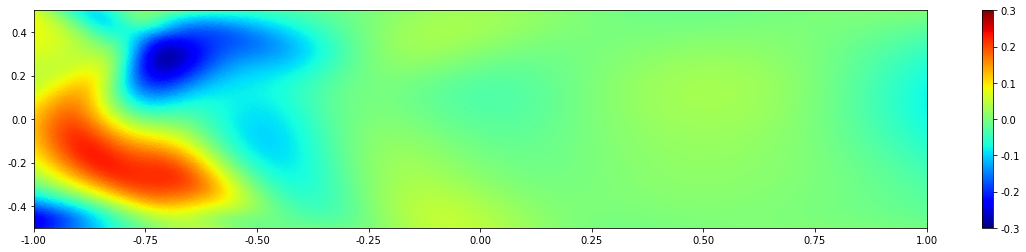

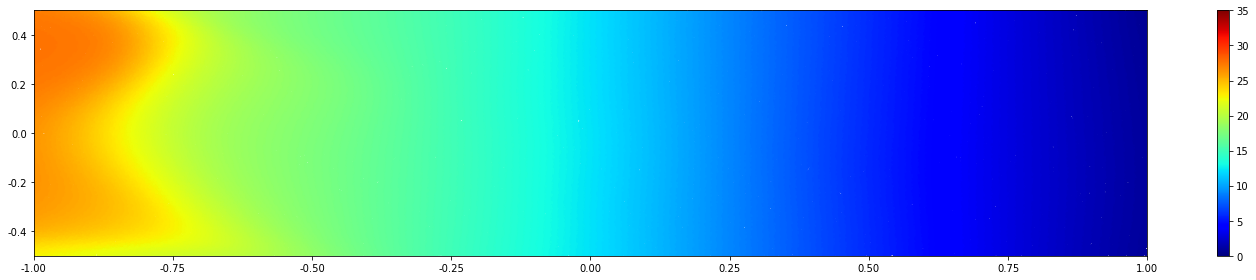

In [59]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]

for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                s = 2,
                cmap = 'jet')
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
plt.tight_layout()
plt.show()

## PINN with small data

In [60]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [61]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)
    
    pde_u = Y[:,0:1] * du_x + Y[:,1:2] * du_y + 1/rho * dp_x - (mu/rho) * (du_xx + du_yy)
    pde_v = Y[:,0:1] * dv_x + Y[:,1:2] * dv_y + 1/rho * dp_y - (mu/rho) * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

In [62]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

In [63]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v, observe_u, observe_v, observe_p], 
                    num_domain = 1000, 
                    num_boundary = 500, 
                    num_test = 1000,
                    train_distribution = 'LHS')

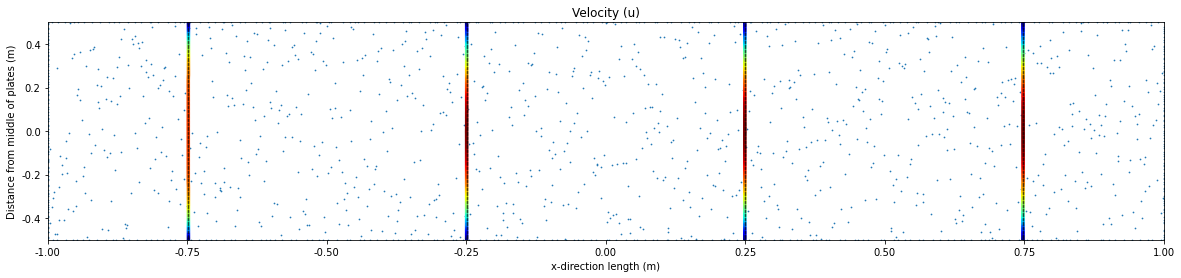

In [64]:
plt.figure(figsize = (20,4))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.scatter(observe_x[:, 0], observe_x[:, 1], c = observe_y[:, 0], s = 6.5, cmap = 'jet')
plt.scatter(observe_x[:, 0], observe_x[:, 1], s = 0.5, color='k', alpha = 0.5)
plt.xlim((0-L/2, L-L/2))
plt.ylim((0-D/2, D-D/2))
plt.xlabel('x-direction length (m)')
plt.ylabel('Distance from middle of plates (m)')
plt.title('Velocity (u)')
plt.show()

In [65]:
layer_size = [2] + [64] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr = 1e-3, loss_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9])

Compiling model...
'compile' took 0.000173 s



In [66]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = False)

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [1.33e-01, 1.12e-01, 3.31e-01, 6.62e-03, 7.31e-02, 1.29e+00, 7.41e-02, 1.34e-01, 7.29e-02, 1.06e+01, 4.63e-01, 1.74e+03]    [1.42e-01, 9.65e-02, 3.51e-01, 6.62e-03, 7.31e-02, 1.29e+00, 7.41e-02, 1.34e-01, 7.29e-02, 1.06e+01, 4.63e-01, 1.74e+03]    []  
1000      [6.29e-02, 3.46e-02, 8.21e-02, 4.50e-02, 2.22e-03, 5.19e-02, 1.00e-03, 2.19e-03, 8.83e-04, 3.71e-02, 2.22e-02, 6.67e-01]    [7.39e-02, 3.94e-02, 9.14e-02, 4.50e-02, 2.22e-03, 5.19e-02, 1.00e-03, 2.19e-03, 8.83e-04, 3.71e-02, 2.22e-02, 6.67e-01]    []  
2000      [1.97e-02, 1.19e-02, 5.24e-02, 1.63e-02, 3.91e-04, 6.73e-02, 1.44e-03, 8.76e-04, 1.41e-04, 2.69e-02, 9.87e-03, 2.24e-01]    [2.43e-02, 1.30e-02, 5.40e-02, 1.63e-02, 3.91e-04, 

Compiling model...
'compile' took 0.000297 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
10000     [4.58e-03, 3.93e-03, 7.00e-02, 1.46e-02, 3.69e-04, 5.34e-02, 8.84e-03, 7.46e-05, 1.92e-05, 1.92e-02, 1.11e-02, 1.95e-02]    [7.81e-03, 9.35e-03, 5.79e-02, 1.46e-02, 3.69e-04, 5.34e-02, 8.84e-03, 7.46e-05, 1.92e-05, 1.92e-02, 1.11e-02, 1.95e-02]    []  
11000     [3.81e-03, 3.21e-03, 2.79e-02, 1.20e-02, 1.78e-03, 1.39e-02, 2.51e-02, 2.15e-05, 6.97e-05, 9.73e-03, 4.95e-03, 4.80e-03]    [1.07e-02, 5.75e-03, 3.19e-02, 1.20e-02, 1.78e-03, 1.39e-02, 2.51e-02, 2.15e-05, 6.97e-05, 9.73e-03, 4.95e-03, 4.80e-03]    []  
12000     [2.94e-03, 3.63e-03, 1.17e-02, 1.01e-02, 5.63e-04, 1.31e-02, 1.12e-02, 5.63e-05, 2.96e-05, 4.28e-03, 2.02e-03, 1.70e-03]    [1.22

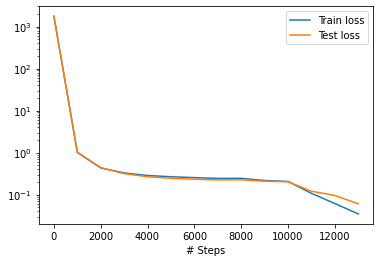

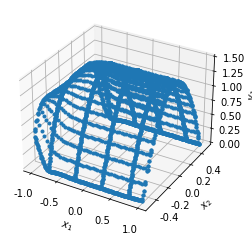

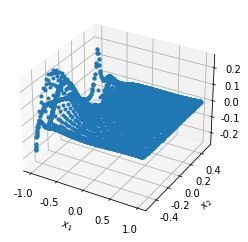

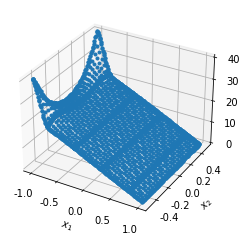

In [67]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile("L-BFGS", loss_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9])
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

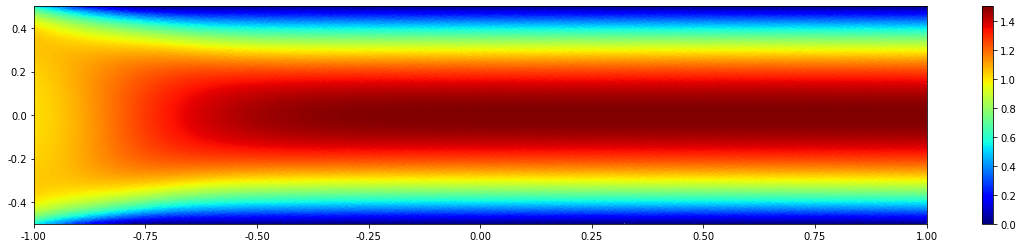

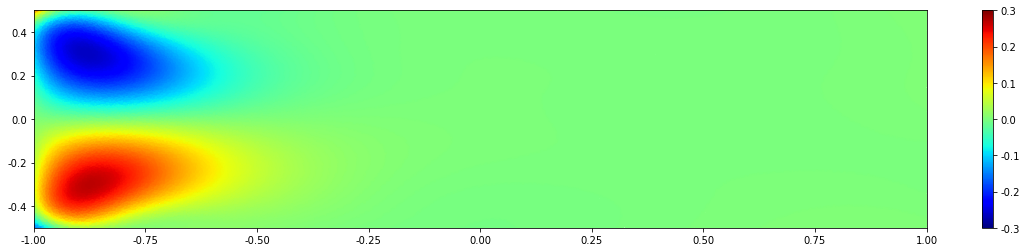

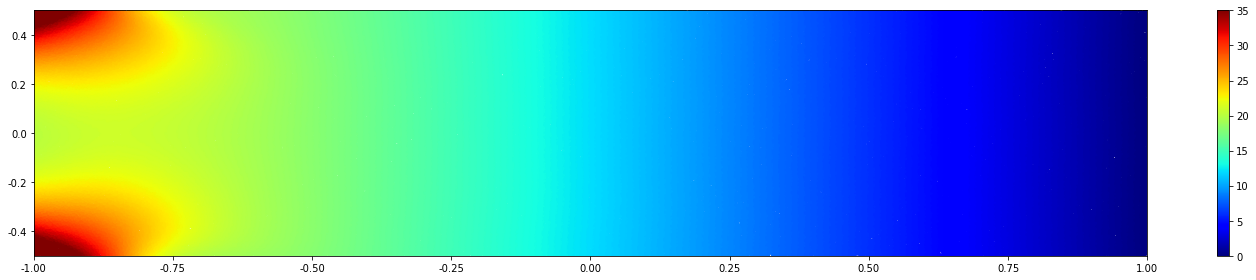

In [68]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]

for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                s = 2,
                cmap = 'jet')
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
plt.tight_layout()
plt.show()